In [2]:
from os import getcwd
import json 
import pinocchio as pin
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

In [3]:
wd = getcwd()

file1_path = wd + '/results/scene2.json'

with open(file1_path, 'r') as file:
    data = json.load(file)

In [4]:
q_dist = [x[:7] for x in data['xs_dist']]
v_dist = [x[7:] for x in data['xs_dist']]

q_vel = [x[:7] for x in data['xs_vel']]
v_vel = [x[7:] for x in data['xs_vel']]

q_nocol = [x[:7] for x in data['xs_nocol']]
v_nocol = [x[7:] for x in data['xs_nocol']]

In [5]:
import pinocchio as pin
import numpy as np
import hppfcl
from numpy import r_, c_, eye
from wrapper_panda import PandaWrapper
from viewer import create_viewer, add_sphere_to_viewer, add_cube_to_viewer
np.set_printoptions(precision=4, linewidth=350, suppress=True,threshold=1e6)

import yaml
from create_ocp import create_ocp_velocity, create_ocp_distance, create_ocp_nocol

# Load variables from the YAML file
with open("config_scenes.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access the 'scene' data
scene = config["scene2"]


#### Creating the robot
robot_wrapper = PandaWrapper()
rmodel, gmodel, vmodel = robot_wrapper()

gmodel.removeGeometryObject("panda1_box_0")
vmodel.removeGeometryObject("panda1_box_0")


PLACEMENT_OBS = [
pin.SE3(pin.utils.rotate("y", np.pi / 2), np.array([0.0, 0.0, 0.9])),
pin.SE3(pin.utils.rotate("y", np.pi / 2), np.array([0.0, 0.4, 0.9])),
pin.SE3(
    pin.utils.rotate("y", np.pi / 2) @ pin.utils.rotate("x", np.pi / 2),
    np.array([-0.2, 0.2, 0.9]),
),
pin.SE3(
    pin.utils.rotate("y", np.pi / 2) @ pin.utils.rotate("x", np.pi / 2),
    np.array([0.2, 0.2, 0.9]),
),
]
DIM_OBS = [[0.09, 0.06, 0.2], [0.09, 0.06, 0.2], [0.09, 0.06, 0.2], [0.09, 0.06, 0.2]]
DIM_ROB = [[0.1, 0.08, 0.15], [0.04, 0.06, 0.04]]

rmodel.addFrame(pin.Frame('obstacle_1',0,0,PLACEMENT_OBS[0],pin.OP_FRAME))
rmodel.addFrame(pin.Frame('obstacle_2',0,0,PLACEMENT_OBS[1],pin.OP_FRAME))
rmodel.addFrame(pin.Frame('obstacle_3',0,0,PLACEMENT_OBS[2],pin.OP_FRAME))
rmodel.addFrame(pin.Frame('obstacle_4',0,0,PLACEMENT_OBS[3],pin.OP_FRAME))

idf_obs_1 = rmodel.getFrameId('obstacle_1')
idj_obs_1 = rmodel.frames[idf_obs_1].parentJoint
elips_obs_1 = hppfcl.Ellipsoid(*DIM_OBS[0])
elips_obs_1_geom = pin.GeometryObject('el_obs_1', idj_obs_1,idf_obs_1,rmodel.frames[idf_obs_1].placement,elips_obs_1)
elips_obs_1_geom.meshColor = r_[1,0,0,1]
idg_obs_1 = gmodel.addGeometryObject(elips_obs_1_geom)

idf_obs_2 = rmodel.getFrameId('obstacle_2')
idj_obs_2 = rmodel.frames[idf_obs_2].parentJoint
elips_obs_2 = hppfcl.Ellipsoid(*DIM_OBS[0])
elips_obs_2_geom = pin.GeometryObject('el_obs_2', idj_obs_2,idf_obs_2,rmodel.frames[idf_obs_2].placement,elips_obs_2)
elips_obs_2_geom.meshColor = r_[1,0,0,1]
idg_obs_2 = gmodel.addGeometryObject(elips_obs_2_geom)

idf_obs_3 = rmodel.getFrameId('obstacle_3')
idj_obs_3 = rmodel.frames[idf_obs_3].parentJoint
elips_obs_3 = hppfcl.Ellipsoid(*DIM_OBS[0])
elips_obs_3_geom = pin.GeometryObject('el_obs_3', idj_obs_3,idf_obs_3,rmodel.frames[idf_obs_3].placement,elips_obs_3)
elips_obs_3_geom.meshColor = r_[1,0,0,1]
idg_obs_3 = gmodel.addGeometryObject(elips_obs_3_geom)

idf_obs_4 = rmodel.getFrameId('obstacle_4')
idj_obs_4 = rmodel.frames[idf_obs_4].parentJoint
elips_obs_4 = hppfcl.Ellipsoid(*DIM_OBS[0])
elips_obs_4_geom = pin.GeometryObject('el_obs_4', idj_obs_4,idf_obs_4,rmodel.frames[idf_obs_4].placement,elips_obs_4)
elips_obs_4_geom.meshColor = r_[1,0,0,1]
idg_obs_4 = gmodel.addGeometryObject(elips_obs_4_geom)

idf_rob_1 = rmodel.getFrameId('panda2_link7_sc')
idj_rob_1 = rmodel.frames[idf_rob_1].parentJoint
elips_rob_1 = hppfcl.Ellipsoid(*DIM_ROB[0])
elips_rob_1_geom = pin.GeometryObject('el_rob_1', idj_rob_1,idf_rob_1,rmodel.frames[idf_rob_1].placement,elips_rob_1)
elips_rob_1_geom.meshColor = r_[1,1,0,1]
idg_rob_1 = gmodel.addGeometryObject(elips_rob_1_geom)

rdata,gdata = rmodel.createData(),gmodel.createData()


In [6]:
def distance_to_obs(q, idg_obs, elips_obs):
        
    pin.forwardKinematics(rmodel, rdata, np.array(q))
    pin.updateFramePlacements(rmodel, rdata)
    pin.updateGeometryPlacements(rmodel, rdata, gmodel, gdata)
    obs_placement = gdata.oMg[idg_obs]
    rob_placement = gdata.oMg[idg_rob_1]
    
    req = hppfcl.DistanceRequest()
    res = hppfcl.DistanceResult()
    
    distance = hppfcl.distance(elips_obs, obs_placement,elips_rob_1, rob_placement, req, res)
    
    return distance    
    

In [7]:
dist_dist_right = []
dist_dist_left = []
dist_dist_front = []
dist_dist_back = []

dist_vel_right = []
dist_vel_left = []
dist_vel_front = []
dist_vel_back = []


for q in q_dist:
    dist_dist_right.append(distance_to_obs(q, idg_obs_1, elips_obs_1))
    dist_dist_left.append(distance_to_obs(q, idg_obs_2, elips_obs_2))
    dist_dist_front.append(distance_to_obs(q, idg_obs_3, elips_obs_3))
    dist_dist_back.append(distance_to_obs(q, idg_obs_4, elips_obs_4))
for q in q_vel:
    dist_vel_right.append(distance_to_obs(q, idg_obs_1, elips_obs_1))
    dist_vel_left.append(distance_to_obs(q, idg_obs_2, elips_obs_2))
    dist_vel_front.append(distance_to_obs(q, idg_obs_3, elips_obs_3))
    dist_vel_back.append(distance_to_obs(q, idg_obs_4, elips_obs_4))
    
    

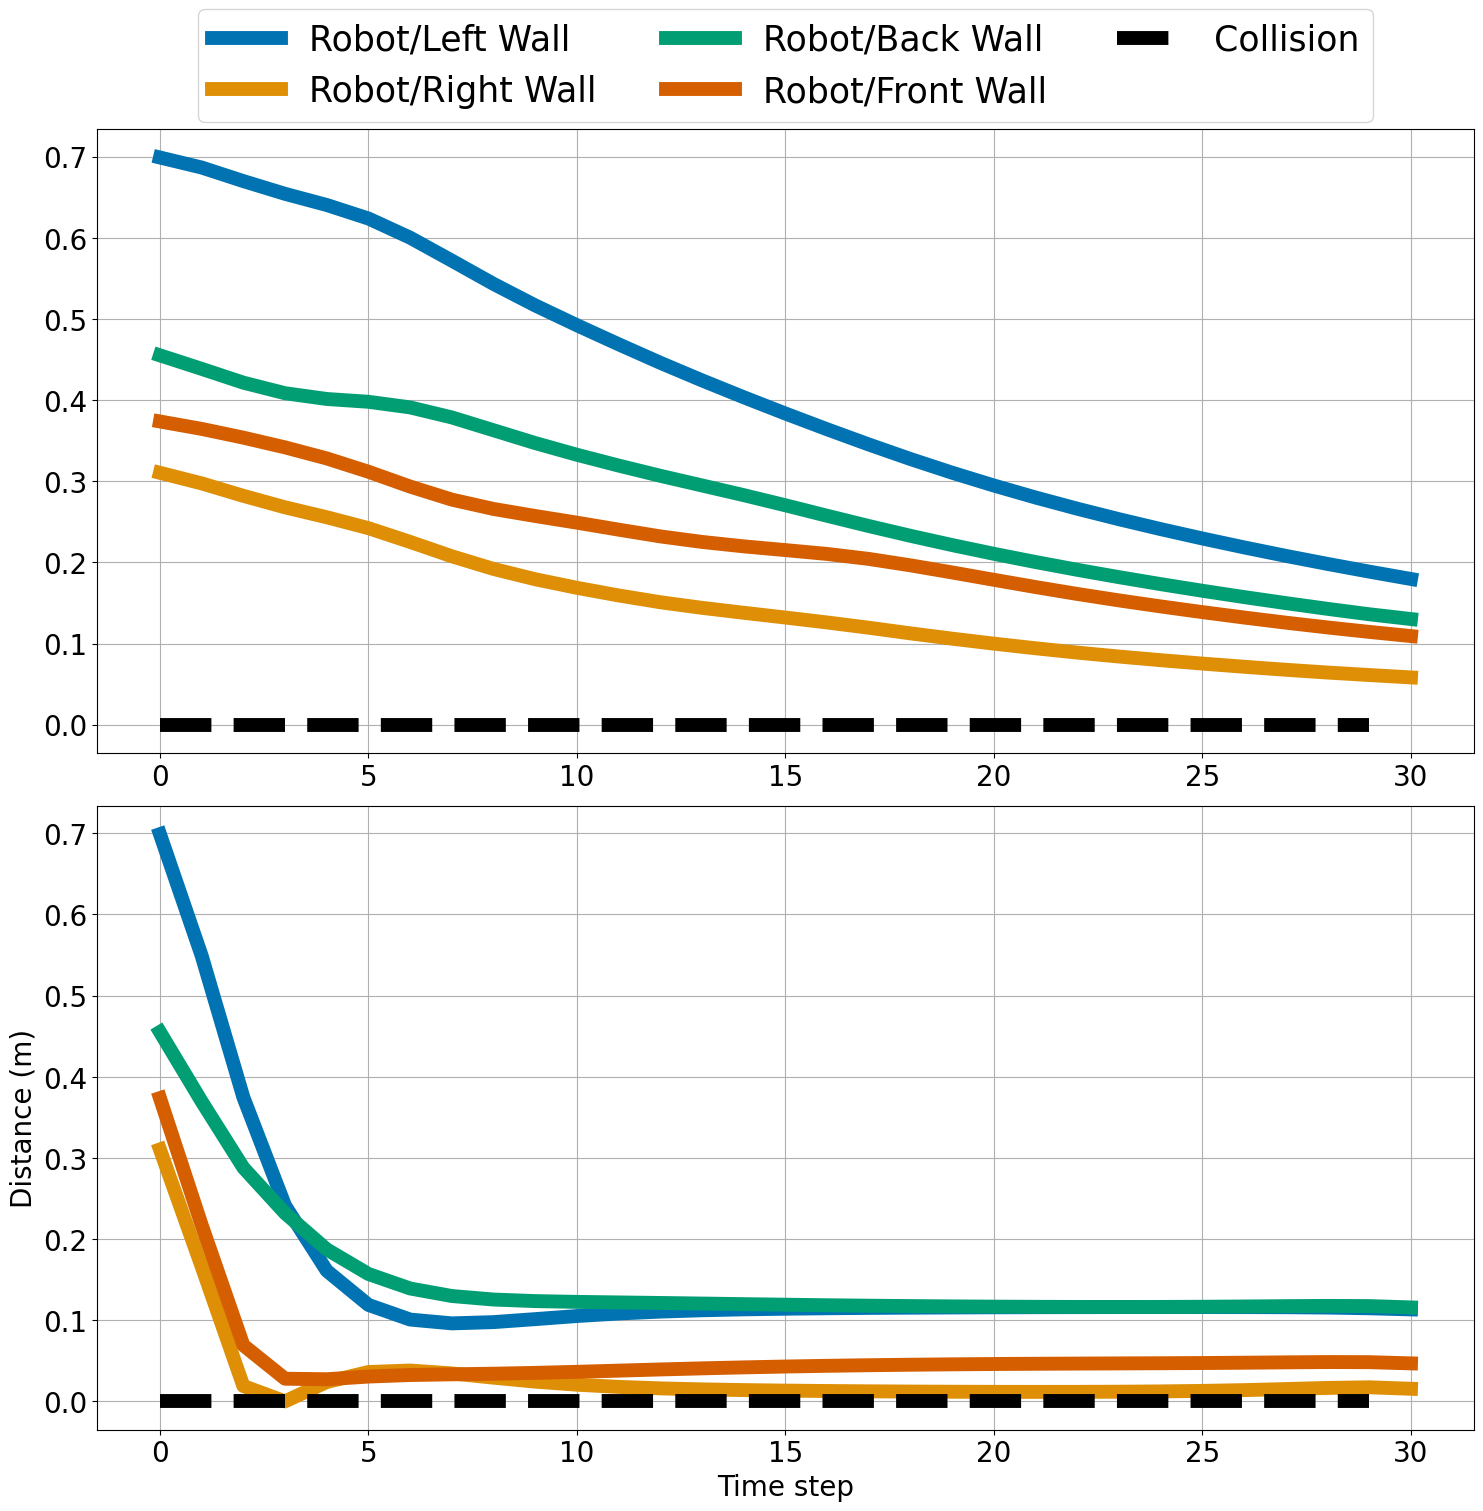

In [12]:
import seaborn as sns
import matplotlib

sns.set_palette("colorblind")
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Plot the distance obstacles
fig = plt.figure(figsize=(15, 15))


plt.subplot(2, 1, 1)

plt.plot(dist_vel_left, '-' ,  linewidth=10, label='Robot/Left Wall')
plt.plot(dist_vel_right, '-' ,  linewidth=10, label='Robot/Right Wall')
plt.plot(dist_vel_back, '-' ,  linewidth=10, label='Robot/Back Wall')
plt.plot(dist_vel_front, '-' ,  linewidth=10, label='Robot/Front Wall')

plt.plot(np.zeros(scene["T"]), 'k--',  linewidth=10, label='Collision')


plt.legend(bbox_to_anchor=(0.5, 1.22), loc='upper center', ncol=3,fontsize=25)
plt.grid()
plt.subplot(2, 1, 2)



plt.plot(dist_dist_left, '-' ,  linewidth=10, label='Robot/Left Wall')
plt.plot(dist_dist_right, '-' ,  linewidth=10, label='Robot/Right Wall')
plt.plot(dist_dist_back, '-' ,  linewidth=10, label='Robot/Back Wall')
plt.plot(dist_dist_front, '-' ,  linewidth=10, label='Robot/Front Wall')

plt.plot(np.zeros(scene["T"]), 'k--',  linewidth=10, label='Collision')
plt.ylabel('Distance (m)', fontsize=20)

# Add labels and title
plt.xlabel('Time step', fontsize=20)
plt.ylabel('Distance (m)', fontsize=20)


plt.tight_layout()
plt.grid()
plt.show()
